In [1]:
import numpy as np
import numpy as np, h5py
from scipy import signal
import scipy.io
from scipy.fftpack import fft

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

import glob

In [2]:
matplotlib.rcParams["figure.figsize"] = [15, 8]

----------

### Matlab to numpy

sampling frequency: 30 kHz

- $f_0$: 10 channels, 10 minutes
- $f_1$: 1 channel, 10 minutes
- $f_2$: 1 channel, 30 minutes

In [3]:
files = glob.glob("data/*.mat")

In [4]:
files

['data/1_channel_30_minutes.mat',
 'data/1_channel_10_minutes.mat',
 'data/10_channels_10_minutes.mat']

In [5]:
f0 = scipy.io.loadmat(files[2])
f1 = scipy.io.loadmat(files[1])
f2 = h5py.File(files[0], "r")

In [9]:
print(f0.keys())
print(f1.keys())
print(f2.keys())

dict_keys(['__header__', '__version__', '__globals__', 'LFP'])
dict_keys(['__header__', '__version__', '__globals__', 'data'])
<KeysViewHDF5 ['LFP1CH']>


In [6]:
a0 = [a[0] for a in np.array(f0.get("LFP"))[0] if a[0].any()]
a1 = np.array(f1.get("data"))[0]
a2 = np.array(f2.get("LFP1CH")).reshape(1, -1)[0]

#### set parameters

In [7]:
sfreq = 30000
N1 = a1.shape[0]
N2 = a2.shape[0]
dur1 = N1 / sfreq
dur2 = N2 / sfreq
freq_domain_1 = np.linspace(0, sfreq, N1)
freq_domain_2 = np.linspace(0, sfreq, N2)
passband = (300, 6000)

A 10 csatornás adatban összesen 18 array volt, de ezek közül csak 8 nem azonosan nulla. Ezek különböző hosszúságúak, az alábbi táblázat szemlélteti a megoszlásukat. Az utolsó két oszlopban kiszámoltam, milyen lenne a mintavételi frekvencia, ha az időtartamot fixen tartjuk, illetve az időtartam, ha a frekvenciát fixáljuk.

In [12]:
pd.DataFrame(pd.Series([a.shape[0] for a in a0]).value_counts()).reset_index().rename(
    columns={"index": "n", 0: "count"}
).assign(
    diff_freq_same_dur=lambda df: round(df["n"] / dur, 2),
    diff_dur_same_freq=lambda df: df["n"] / sfreq,
).sort_values(
    "n"
)

,n,count,diff_freq_same_dur,diff_dur_same_freq
0,68608,2,111.52,2.286933
2,6401024,2,10404.46,213.367467
3,18456576,2,30000.00,615.219200
1,40073216,2,65136.48,1335.773867


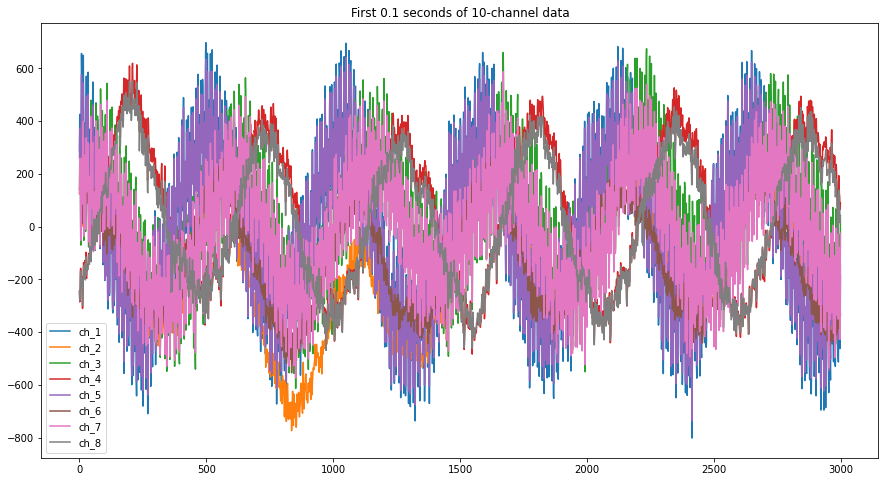

In [17]:
for idx, n in enumerate(a0):
    plt.plot(n[:3000], label=f"ch_{idx + 1}")

plt.title("First 0.1 seconds of 10-channel data")
plt.legend()

Text(0.5, 1.0, 'First second of 10 min signal')

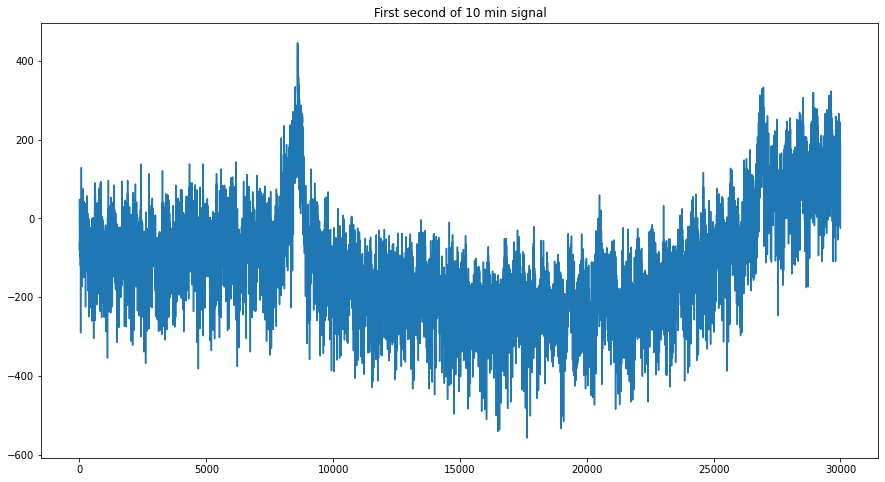

In [15]:
plt.plot(a1[:30000])
plt.title("First second of 10 min signal")

Text(0.5, 1.0, 'First second of 30 min signal')

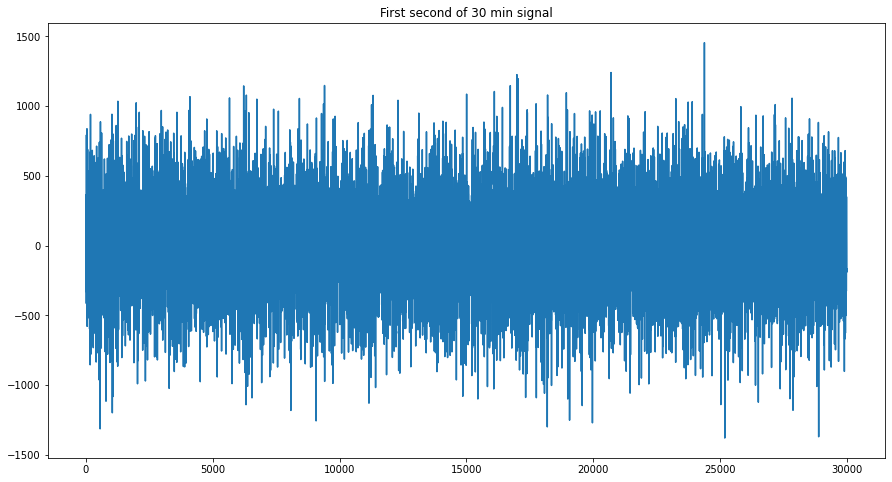

In [16]:
plt.plot(a2[:30000])
plt.title("First second of 30 min signal")

---------------

### Fourier transform

A világoskékkel színezett terület a kívánt frekvencia-tartomány.

In [9]:
ft1 = fft(a1)
ft2 = fft(a2)

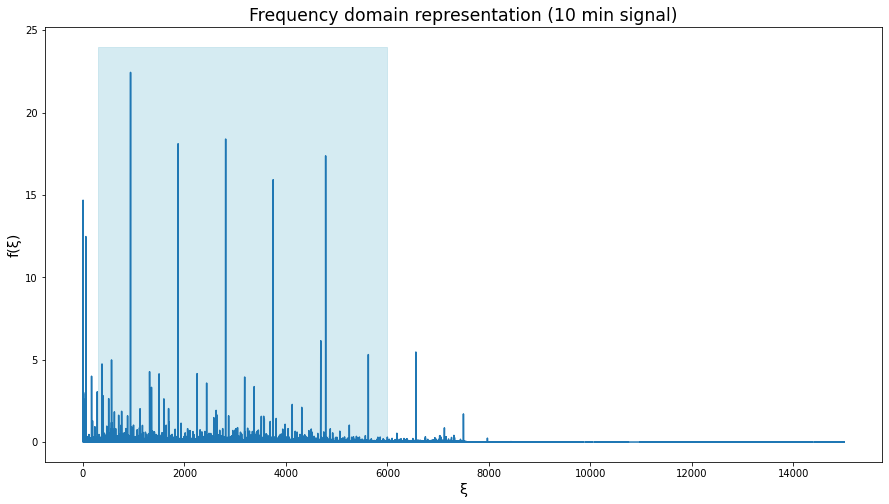

In [12]:
plt.plot(freq_domain_1[: N1 // 2], 2.0 / N1 * np.abs(ft1[: N1 // 2]))
plt.title("Frequency domain representation (10 min signal)", fontsize="xx-large")
plt.xlabel("ξ", fontsize="x-large")
plt.ylabel("f(ξ)", fontsize="x-large")
plt.fill_betweenx(np.arange(0, 25), *passband, color="lightblue", alpha=0.5)

In [ ]:
plt.plot(freq_domain_2[: N2 // 2], 2.0 / N2 * np.abs(ft2[: N2 // 2]))
plt.title("Frequency domain representation (30 min signal)", fontsize="xx-large")
plt.xlabel("ξ", fontsize="x-large")
plt.ylabel("f(ξ)", fontsize="x-large")
plt.fill_betweenx(np.arange(0, 25), *passband, color="lightblue", alpha=0.5)

-------------

### Design bandpass filter

300-6000 Hz bandpass filter

#### [Butterworth filter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html) ([on Wikipedia](https://en.wikipedia.org/wiki/Butterworth_filter#:~:text=A%20second%2Dorder%20filter%20decreases,passband%20and%2For%20the%20stopband.))

#### [Bidirectional digital filter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.sosfiltfilt.html#scipy.signal.sosfiltfilt)

#### [Pitfalls of Filtering the EEG Signal](https://sapienlabs.org/pitfalls-of-filtering-the-eeg-signal/)

In [9]:
sos = signal.butter(10, passband, btype="bandpass", fs=sfreq, output="sos",)

In [14]:
w, h = signal.sosfreqz(sos)

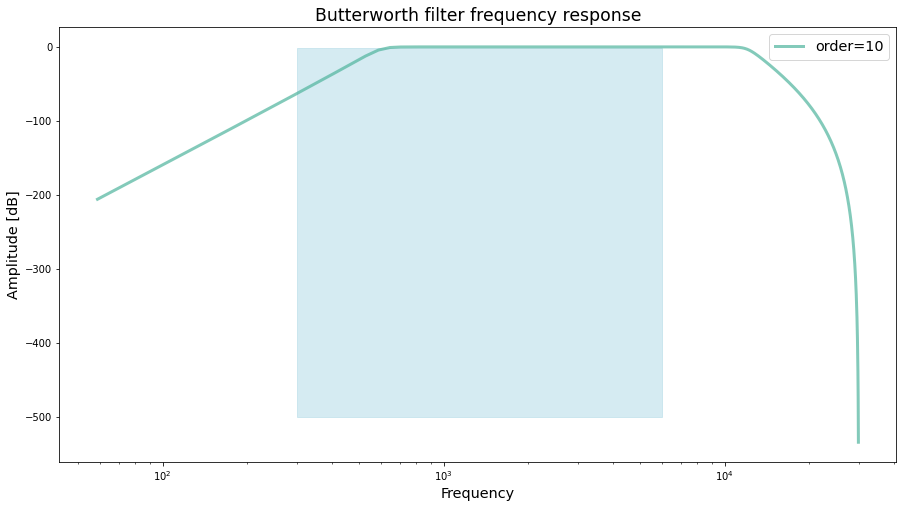

In [17]:
plt.plot(
    w[1:] / np.pi * sfreq,
    20 * np.log10(abs(h[1:])),
    label="order=10",
    linewidth=3,
    alpha=0.7,
    c="#4fb49d",
)

plt.fill_betweenx(np.arange(-500, 0), *passband, color="lightblue", alpha=0.5)
plt.xscale("log")
plt.title("Butterworth filter frequency response", fontsize="xx-large")
plt.xlabel("Frequency", fontsize="x-large")
plt.ylabel("Amplitude [dB]", fontsize="x-large")
plt.legend(fontsize="x-large")

---------

### Apply filter

Az ábrán látható, hogy leszűrte a 300-6000 Hz-es tartományra.

In [10]:
filtered_1 = signal.sosfiltfilt(sos, a1)
filtered_2 = signal.sosfiltfilt(sos, a2)

In [19]:
ft_filtered_1 = fft(filtered_1)
ft_filtered_2 = fft(filtered_2)

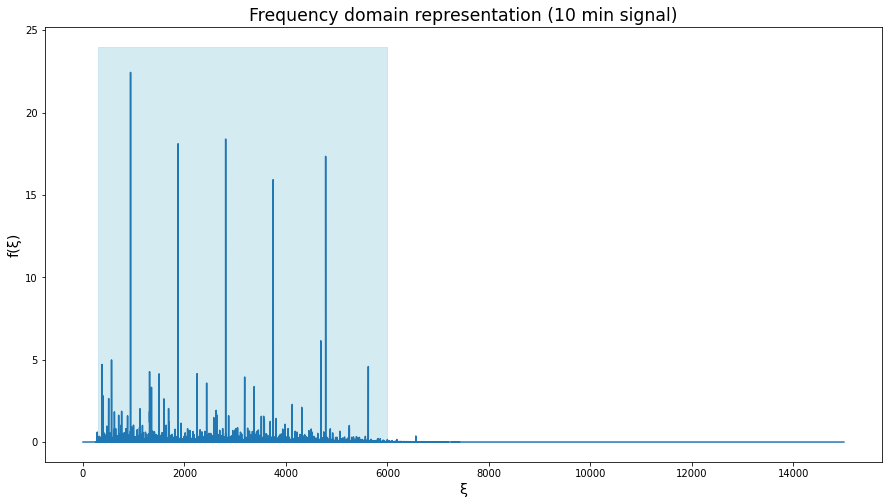

In [20]:
plt.plot(freq_domain_1[: N1 // 2], 2.0 / N1 * np.abs(ft_filtered_1[: N1 // 2]))
plt.title("Frequency domain representation (10 min signal)", fontsize="xx-large")
plt.xlabel("ξ", fontsize="x-large")
plt.ylabel("f(ξ)", fontsize="x-large")
plt.fill_betweenx(np.arange(0, 25), *passband, color="lightblue", alpha=0.5)

In [ ]:
plt.plot(freq_domain_2[: N2 // 2], 2.0 / N2 * np.abs(ft_filtered_2[: N2 // 2]))
plt.title("Frequency domain representation (30 min signal)", fontsize="xx-large")
plt.xlabel("ξ", fontsize="x-large")
plt.ylabel("f(ξ)", fontsize="x-large")
plt.fill_betweenx(np.arange(0, 25), *passband, color="lightblue", alpha=0.5)

In [20]:
np.save('1_ch_10_min_filtered.npy', filtered_1)
np.save('1_ch_30_min_filtered.npy', filtered_2)